# Trading Signal Generation
- applied labels by observing whether the USD/BRL exchange rate increased, decreased, or experienced low volatility (neutral)
- applied threshold of 0.2% applied to manually determining neutral days
- applied word2vec model to vectorize text and further classify new articles to generate buy/sell/hold signals

Notes (in-progress)
- avoid data-leakage: don't train/test on the same data

Checking Dates in articles

In [1]:
# checking what dates are in our file filled with articles

import re
import pandas as pd

def extract_dates_from_file(file_path):
    date_pattern = r'\d{2}/\d{2}/\d{2}'
    dates = []
    
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
        matches = re.findall(date_pattern, content)
        dates.extend(matches)
    
    dates_df = pd.DataFrame(dates, columns=['Date'])
    return dates_df

file_path = 'data/news_corpus_cleaned.txt'
dates_df = extract_dates_from_file(file_path)
display(dates_df)

,Date
0,09/01/24
1,10/01/24
2,11/01/24
3,12/01/24
4,15/01/24
5,16/01/24
6,19/01/24
7,22/01/24
8,23/01/24
9,24/01/24


Organizing article file data into a DataFrame for readability and easier to convert to CSV

In [3]:
import pandas as pd
import re
from datetime import datetime

# look at the file and make it into a list
def parse_articles_to_df(file_path):
    dates = []  # keep the dates
    articles = []  # keep the articles
    
    with open(file_path, "r", encoding="utf-8") as file:
        current_date = None  # keep the date we are looking at right now
        current_articles = []  # keep the article for the current date
        
        for line in file:
            line = line.strip()  # take away spaces from the start and end
            if line:  # if the line is not empty
                if line[2] == "/":  # if the line looks like a date (dd/mm/yy)
                    # we had a date before, so let's save it with its articles
                    if current_date:
                        for article in current_articles:
                            dates.append(current_date)  # add current date
                            articles.append(article)  # add article for that date
                    # use the date as is, don't change it
                    current_date = line  # keep new date
                    current_articles = []  # start fresh for new date
                else:
                    # 'line' is the article, keep adding them to the list
                    current_articles.append(line) 
        
        if current_date:  # when we are done looking at the file
            for article in current_articles:  # for all the articles we saved
                dates.append(current_date)  # add the date again
                articles.append(article)  # add the article again
    
    df = pd.DataFrame({'date': dates, 'article': articles})  # make table with the dates and articles
    return df  # display table

file_path = "data/news_corpus_cleaned.txt"  # where the file is
df_articles = parse_articles_to_df(file_path)  # call the function to make the table

# show the table to see it
display(df_articles.head())

,date,article
0,09/01/24,"O petróleo testava reação moderada (+0,50%) no..."
1,09/01/24,Circularam comentários de que a reunião de Pac...
2,09/01/24,"De qualquer modo, seis senadores estão com a p..."
3,09/01/24,"Nos EUA, sai a balança comercial de novembro (..."
4,09/01/24,"O investidor cumpre a espera pela 5ªF, que pro..."


Preprocessing

In [4]:
import spacy

# spacy PT model
nlp = spacy.load('pt_core_news_sm')

#preprocessing
def preprocess_text_spacy(text):
    doc = nlp(text)
    
    # lemmatization and stopwords removal
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    
    #tokens back to 1 string
    return ' '.join(tokens)

# preprocess ALL articles in df (the file)
df_articles['processed_article'] = df_articles['article'].apply(preprocess_text_spacy)

# Display the processed articles
display(df_articles)

,date,article,processed_article
0,09/01/24,"O petróleo testava reação moderada (+0,50%) no...",petróleo testar reação moderar pregão asiático...
1,09/01/24,Circularam comentários de que a reunião de Pac...,circularam comentário reunião Pacheco líder se...
2,09/01/24,"De qualquer modo, seis senadores estão com a p...",modo senador presença confirmar Único indicado...
3,09/01/24,"Nos EUA, sai a balança comercial de novembro (...",EUA sair balança comercial novembro Fed boy Mi...
4,09/01/24,"O investidor cumpre a espera pela 5ªF, que pro...",investidor cumprir espera prometer emoção CPI ...
...,...,...,...
1096,31/01/24,Emissão é de apenas uma série e já tem valor d...,Emissão série definir revelar executivo
1097,31/01/24,"ROMI teve lucro líquido de R$ 51,340 milhões n...",ROMI lucro líquido milhão queda
1098,31/01/24,ENEVA. Citi manteve recomendação de compra par...,ENEVA Citi manter recomendação compra ação ban...
1099,31/01/24,OI. Nova versão do plano de recuperação judici...,OI versão plano recuperação judicial concluir ...


Applying the Word2Vec approach

In [5]:
from gensim.models import Word2Vec

tokenized_articles = df_articles['processed_article'].apply(lambda x: x.split()).tolist()

model = Word2Vec(sentences=tokenized_articles, 
                 vector_size=100,   # dimensionality of the word embeddings
                 window=5,          # context window size
                 min_count=5,       # minimum frequency of words to consider
                 workers=4,         # CPUs for training
                 sg=0)              # Use CBOW (0) or Skip-Gram (1)

model.save("word2vec.model")

Counting the number of each label in our data (3 classes)
- helps us to realize a class imbalance
- good to keep track of

In [6]:
import pandas as pd

file_path = 'data/labeled_articles.csv'
df = pd.read_csv(file_path)

column_name = 'label'
column_data = df[column_name]

df_articles['label'] = column_data

counts = column_data.value_counts()

count_1 = counts[1]
count_minus_1 = counts[-1]
count_0 = counts[0]

print(f"Count of 1: {count_1}")
print(f"Count of -1: {count_minus_1}")
print(f"Count of 0: {count_0}")

Count of 1: 182
Count of -1: 363
Count of 0: 556


Labeling of all articles on trading day "d" based on whether the USD/BRL exchange rate increased/decreased or hovered around a .5% increase/decrease on trading day "d"
- Increase: +1
- Decrease: -1
- Neutral: 0

fail

In [6]:
'''
# Word2Vec approach by applying +1, -1, 0 labels to ALL articles per trading day whether the BRL went up down or stayed around the same based on a .2% threshold.
# 0 for neutral
# +1 for up
# -1 for down

labels = {
    '09/01/24': 1,
    '10/01/24': 0,
    '11/01/24': -1,
    '12/01/24': -1, 
    '15/01/24': 1,
    '16/01/24': 1,
    '19/01/24': 0,
    '22/01/24': 1,
    '23/01/24': -1,
    '24/01/24': -1,
    '25/01/24': -1,
    '26/01/24': -1,
    '29/01/24': 1,
    '30/01/24': 1,
    '31/01/24': 1
}

# add lablels to df
df_articles['label'] = df_articles['date'].map(labels)
'''


"\n# Word2Vec approach by applying +1, -1, 0 labels to ALL articles per trading day whether the BRL went up down or stayed around the same based on a .2% threshold.\n# 0 for neutral\n# +1 for up\n# -1 for down\n\nlabels = {\n    '09/01/24': 1,\n    '10/01/24': 0,\n    '11/01/24': -1,\n    '12/01/24': -1, \n    '15/01/24': 1,\n    '16/01/24': 1,\n    '19/01/24': 0,\n    '22/01/24': 1,\n    '23/01/24': -1,\n    '24/01/24': -1,\n    '25/01/24': -1,\n    '26/01/24': -1,\n    '29/01/24': 1,\n    '30/01/24': 1,\n    '31/01/24': 1\n}\n\n# add lablels to df\ndf_articles['label'] = df_articles['date'].map(labels)\n"

In [7]:
import numpy as np
from scipy.spatial.distance import cdist
import itertools  # needed this for combinations

# function to get the article vector by averaging word vectors
def get_article_vector(article, model):
    tokens = article.split()  # split the article into words
    # get the word vectors for each word that exists in the model's vocabulary
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) > 0:  # if there are any word vectors
        return np.mean(vectors, axis=0)  # average them to get a single vector
    else:
        return np.zeros(model.vector_size)  # if no word vectors, return a zero vector

# convert all articles into vectors
df_articles['article_vector'] = df_articles['processed_article'].apply(lambda x: get_article_vector(x, model))

# assuming 'labels' is a column with +1, 0, -1 labels
labels = df_articles['label'].values  # get the labels

In [8]:
# Checking the data we're working with before feeding it into the model

df_articles.to_csv('input_log_reg.csv')

Multinomial Logistic Regression Model with Custom Word2Vec Model

Next steps:
- Apply softmax to improve accuracy
- Train on January, test on first 2 weeks of February
    - Or grab equal amounts of each label and make sure to test on NEW articles since the training data may come from spread out dates

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd

# Step 1: Prepare the data (X = article vectors, y = labels)
X = np.vstack(df_articles['article_vector'].values)
y = df_articles['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    class_weight='balanced',
    C=1.0,
    penalty='l2'
)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

X_all = np.vstack(df_articles['article_vector'].values)
predicted_labels = clf.predict(X_all)
df_articles['predicted_label'] = predicted_labels

# Step 5: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)

# Classification report
classification_rep = classification_report(y_test, y_pred, output_dict=True)  # Get classification report as dictionary

# Convert evaluation results into DataFrames for better display
classification_rep_df = pd.DataFrame(classification_rep).transpose()

# Step 6: Display the results
print("Accuracy:", accuracy)
display("Classification Report:")
display(classification_rep_df)

display(df_articles)

Accuracy: 0.5113122171945701


'Classification Report:'

,precision,recall,f1-score,support
-1,0.483051,0.670588,0.561576,85.000000
0,0.553191,0.530612,0.541667,98.000000
1,0.444444,0.105263,0.170213,38.000000
accuracy,0.511312,0.511312,0.511312,0.511312
macro avg,0.493562,0.435488,0.424485,221.000000
weighted avg,0.507516,0.511312,0.485454,221.000000


,date,article,processed_article,label,article_vector,predicted_label
0,09/01/24,"O petróleo testava reação moderada (+0,50%) no...",petróleo testar reação moderar pregão asiático...,0,"[-0.009849163, 0.027844377, 0.0054197526, -0.0...",0
1,09/01/24,Circularam comentários de que a reunião de Pac...,circularam comentário reunião Pacheco líder se...,0,"[-0.012140537, 0.03833763, 0.0041473075, 0.001...",0
2,09/01/24,"De qualquer modo, seis senadores estão com a p...",modo senador presença confirmar Único indicado...,0,"[-0.008311338, 0.04356175, 0.009121168, -0.002...",0
3,09/01/24,"Nos EUA, sai a balança comercial de novembro (...",EUA sair balança comercial novembro Fed boy Mi...,-1,"[-0.0154387755, 0.05318188, 0.0063531273, 0.00...",-1
4,09/01/24,"O investidor cumpre a espera pela 5ªF, que pro...",investidor cumprir espera prometer emoção CPI ...,-1,"[-0.020878803, 0.066592336, 0.011039495, 0.004...",-1
...,...,...,...,...,...,...
1096,31/01/24,Emissão é de apenas uma série e já tem valor d...,Emissão série definir revelar executivo,0,"[-0.0019120121, 0.032052178, -0.0033759382, -0...",0
1097,31/01/24,"ROMI teve lucro líquido de R$ 51,340 milhões n...",ROMI lucro líquido milhão queda,0,"[-0.017135266, 0.044564977, 0.005355703, 0.004...",0
1098,31/01/24,ENEVA. Citi manteve recomendação de compra par...,ENEVA Citi manter recomendação compra ação ban...,0,"[-0.011017008, 0.04255183, 0.004526467, -0.000...",0
1099,31/01/24,OI. Nova versão do plano de recuperação judici...,OI versão plano recuperação judicial concluir ...,0,"[-0.019630598, 0.051003158, 0.002942844, 0.006...",-1


In [ ]:
df_articles.to_csv("classified_articles.csv", index=False, encoding="utf-8")

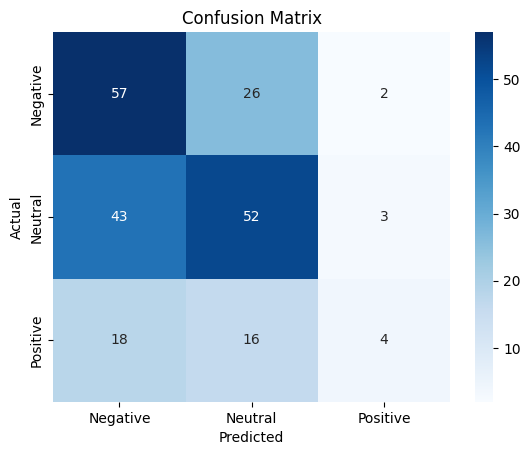

In [10]:
# Confusion Matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# y_test is actual labels and y_pred is predicted labels
cm = confusion_matrix(y_test, y_pred)

# heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# display plot
plt.show()